In [1]:
import pandas as pd
from glob import glob
import seaborn as sns

In [2]:
def span_attr(span, key):
    data = pd.DataFrame(span.at['attributes'])
    attr = data[data['key'] == key]
    if not attr.empty:
        return attr['value'].values[0]['stringValue']

In [3]:
def span_event(span, name):
    # print(span)
    # print(type(span))
    if 'events' not in span:
        return
    data = pd.DataFrame(span.at['events'])
    event = data[data['name'] == name]
    if not event.empty:
        return event.squeeze()

In [4]:
def report_trace(name):
    data = pd.read_json(f'{name}.json', orient='record')
    span = data[data['name'] == 'CoreAPI.UnixfsAPI.Get']
    cid = span_attr(span.squeeze(), 'path').split('/')[-1]
    # print('cid', cid)
    cmd_span = data[data['name'] == 'corehttp.cmdsHandler']
    start_nano = cmd_span['startTimeUnixNano'].values[0]
    end_nano = cmd_span['endTimeUnixNano'].values[0]
    transfer_start_nano = data[data['name'] == 'Blockservice.Session.GetBlocks']['startTimeUnixNano'].values[0]
    first_block_notify = data[data['name'] == 'Bitswap.NotifyNewBlocks']['startTimeUnixNano'].min()

    other_data = pd.read_json(f'{name}_other.json', orient='record')
    def find_key(span):
        return (
            span.at['name'] == 'Dual.FindProvidersAsync' 
            and span_attr(span, 'key') == cid)
    find_span = other_data[other_data.apply(find_key, axis=1)]
    # find_start_nano = int(span_event(find_span.squeeze(), 'started streaming').at['timeUnixNano'])
    if find_span.empty:
        print(f'! No FindProviders span in trace of {cid}')
        return pd.Series()
    if len(find_span) != 1:
        print(f'! Multiple FindProviders spans in trace of {cid}')
        return pd.Series()
    find_start_nano = find_span['startTimeUnixNano'].values[0]
    
    # print('find delay', (find_start_nano - start_nano) / 10**9)
    find_delay = (find_start_nano - start_nano) / 10**9
    if (find_end_event := span_event(find_span.squeeze(), 'found provider')) is None:
        print(f'! No FindProvider event in trace of {cid}')
        return pd.Series()
    find_end_nano = int(find_end_event.at['timeUnixNano'])
    # print('find', (find_end_nano - find_start_nano) / 10**9)
    find = (find_end_nano - find_start_nano) / 10**9
    # print('from find to first block arrive', (first_block_notify - find_end_nano) / 10**9)
    first_block = (first_block_notify - find_end_nano) / 10**9
    # print('transfer', (end_nano - transfer_start_nano) / 10**9)
    transfer = (end_nano - transfer_start_nano) / 10**9
    # print('total', (end_nano - start_nano) / 10**9)
    total = (end_nano - start_nano) / 10**9
    return pd.Series({'cid': cid, 'start nano': start_nano, 'find delay': find_delay, 'find': find, 'first block': first_block, 'transfer': transfer, 'total': total})

In [5]:
report_data_apse2 = pd.DataFrame([
    report_trace(name.split('_')[0])
    for name in glob('data.get.apse/traces.apse2/*_other.json')
])
report_data_apse2

! No FindProviders span in trace of QmPEnVzExxYUaLmD4WgpDXEhf5uTLktuUm349Vt3nWiE9c
! No FindProvider event in trace of QmayR6VghNWWMA16oGYziKPsXTZ3ArBU2YjdAKENayZfb6


,cid,start nano,find delay,find,first block,transfer,total
0,QmXtKLsCqbynTJhC9Y8xzYvnj6Qbb8LF1BN7CGCXRqitRd,1.710382e+18,1.001087,0.322372,0.034934,0.488747,1.860214
1,QmcAbvnpArGNfCnAGo2cpK3j51K8TkFCAGbeZNbjZB5Ln7,1.710383e+18,1.000845,0.225838,0.036559,0.135545,1.399988
2,QmdAzEjRSNL8Mxf85YVaoaaSFsgkTKTWKzZPwKmAkmsW1e,1.710381e+18,1.001134,1.004392,0.034789,0.266385,2.308703
3,QmXVm6pimoLFFyvvwkNs8XdHvwwM7PJ36oR86z1M4jzAGS,1.710381e+18,1.000876,0.011770,0.031782,0.123615,1.168887
4,QmQrLUZGWfgWEfX7vbqFtidwargBQag9bbJN6ih2nCUKpb,1.710381e+18,1.001267,0.743510,0.029264,0.602486,2.387700
...,...,...,...,...,...,...,...
96,QmcE1qiJ7tJXDC2gfokimzLAtopHypVKXy6r3jaZb18dgS,1.710382e+18,1.000814,0.531548,0.030134,0.255164,1.825240
97,QmZuWtj4iQao3pXEGM5GLecszcfSoVTfokTDqMmpYFoJ48,1.710383e+18,1.001476,0.070127,0.017727,0.121775,1.217595
98,QmYGXJ85aZmk34CrjHxkpV1kkLBQPTJxF7o1kZHjBoG8KJ,1.710382e+18,1.001615,0.749496,0.032793,0.251988,2.037123
99,QmSYQ5ZaDxgaLGHA5KY263VThNxyPN6rAnMDFYoyzx5Zgs,1.710382e+18,1.001426,0.567552,0.051085,0.289763,1.910876


In [6]:
report_data_afs = pd.DataFrame([
    report_trace(name.split('_')[0])
    for name in glob('data.get.apse/traces.afs/*_other.json')
])
report_data_sae = pd.DataFrame([
    report_trace(name.split('_')[0])
    for name in glob('data.get.apse/traces.sae/*_other.json')
])
report_data_apse = pd.DataFrame([
    report_trace(name.split('_')[0])
    for name in glob('data.get.apse/traces.apse/*_other.json')
])

! No FindProviders span in trace of Qmc8S9vj9x41NuXQnhYotMgcQZurEKgM9hnPxtutMD5ivx
! Multiple FindProviders spans in trace of QmcGJVkmgr7v5iArJ6J5bitSHFJ8JZSeaxXTPiJjymLESY
! No FindProviders span in trace of QmbxB7mBFeiZPq8YrPhGNvX5mmqZTkTPuRRXMjLdQ1WcqY
! No FindProviders span in trace of QmTn94fHRqswXp1DrvsfxctqzSjnvbTu4RsYD17WeS3j2F
! No FindProviders span in trace of QmasgiB7n4VRPZpRE9AiGAjQoHrjbLwkqGMsQuyGAjgr7E


In [7]:
report_data_sae.describe()

,start nano,find delay,find,first block,transfer,total
count,9.900000e+01,99.000000,99.000000,99.000000,99.000000,99.000000
mean,1.710328e+18,1.001379,0.745072,1.036653,2.547233,5.333450
std,1.465637e+12,0.000465,0.279354,0.129906,0.576125,0.657165
min,1.710325e+18,1.000654,0.074048,0.998834,2.281169,4.648857
25%,1.710327e+18,1.001023,0.538736,1.005519,2.382315,4.963852
50%,1.710328e+18,1.001393,0.739345,1.008041,2.410214,5.267944
75%,1.710329e+18,1.001671,0.926803,1.015411,2.571351,5.450613
max,1.710330e+18,1.003505,1.566247,1.680390,7.750509,10.448476


In [8]:
report_data_apse.describe()

,start nano,find delay,find,first block,transfer,total
count,9.900000e+01,99.000000,99.000000,99.000000,99.000000,99.000000
mean,1.710322e+18,1.001361,0.648226,0.045812,0.293955,1.995168
std,9.556082e+11,0.000620,0.335588,0.045388,0.142581,0.373102
min,1.710321e+18,1.000485,0.046518,-0.009859,0.119288,1.286711
25%,1.710322e+18,1.000962,0.399076,0.029262,0.177210,1.741007
50%,1.710322e+18,1.001237,0.609942,0.037970,0.263963,2.003612
75%,1.710323e+18,1.001571,0.847964,0.046677,0.378408,2.253714
max,1.710324e+18,1.004853,1.491972,0.308877,0.918962,2.879407


In [9]:
report_data_afs.describe()

,start nano,find delay,find,first block,transfer,total
count,9.900000e+01,99.000000,99.000000,99.000000,99.000000,99.000000
mean,1.710390e+18,1.001352,0.711032,0.686890,1.629380,4.032299
std,1.370242e+12,0.000735,0.331039,0.136995,0.197124,0.452423
min,1.710388e+18,1.000587,0.053474,-0.100638,1.273531,2.954684
25%,1.710389e+18,1.000972,0.474579,0.656785,1.531536,3.773298
50%,1.710390e+18,1.001262,0.712127,0.660264,1.562836,3.972585
75%,1.710391e+18,1.001596,0.923727,0.667743,1.606633,4.298840
max,1.710393e+18,1.007124,1.638689,1.100440,2.394943,5.510304


<Axes: ylabel='Proportion'>

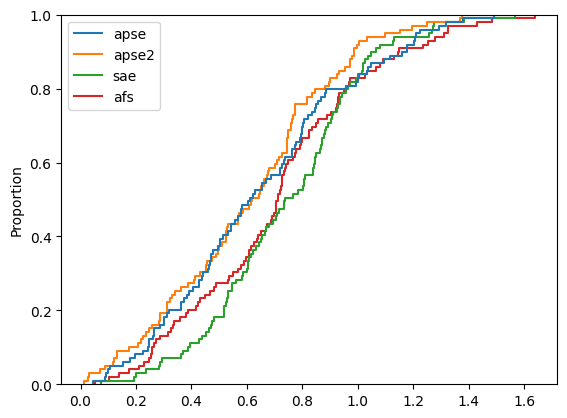

In [10]:
sns.ecdfplot(data={
    'apse': report_data_apse['find'], 
    'apse2': report_data_apse2['find'], 
    'sae': report_data_sae['find'],
    'afs': report_data_afs['find'],
})

<Axes: >

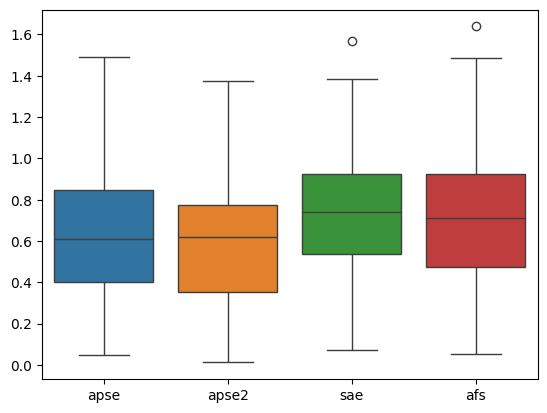

In [11]:
sns.boxplot(data={
    'apse': report_data_apse['find'], 
    'apse2': report_data_apse2['find'], 
    'sae': report_data_sae['find'],
    'afs': report_data_afs['find'],
})

<Axes: ylabel='Proportion'>

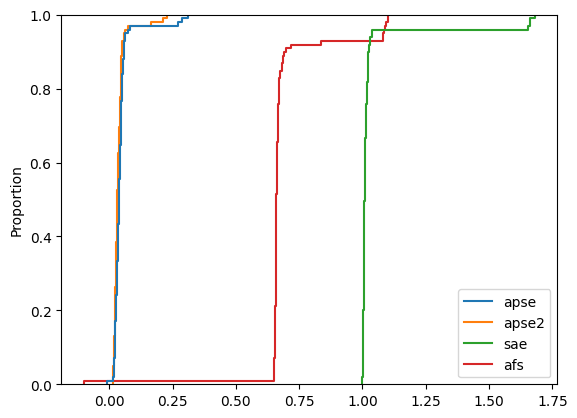

In [31]:
sns.ecdfplot(data={
    'apse': report_data_apse['first block'], 
    'apse2': report_data_apse2['first block'], 
    'sae': report_data_sae['first block'],
    'afs': report_data_afs['first block'],
})

<Axes: ylabel='Proportion'>

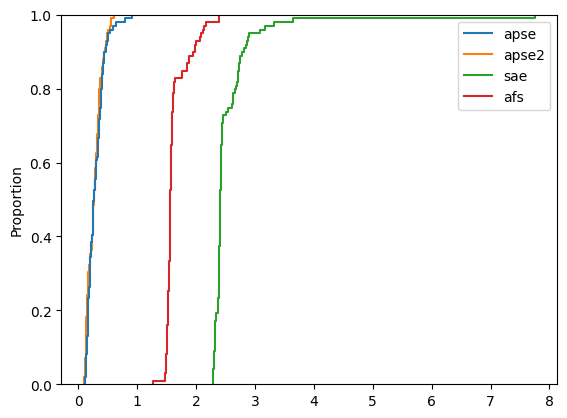

In [32]:
sns.ecdfplot(data={
    'apse': report_data_apse['transfer'], 
    'apse2': report_data_apse2['transfer'], 
    'sae': report_data_sae['transfer'],
    'afs': report_data_afs['transfer'],
})

<Axes: xlabel='start nano', ylabel='find'>

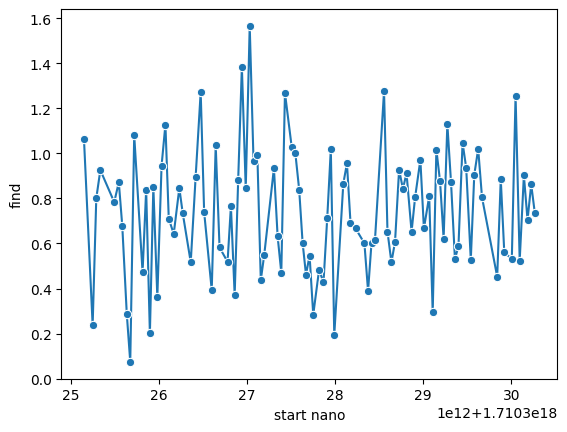

In [33]:
sns.lineplot(data=report_data_sae, x='start nano', y='find', marker='o')

*Backup experiment cells*

In [16]:
data = pd.read_json('traces/2024-03-14T12:13:53.733689623Z_other.json', orient='record')

In [ ]:
span = data[data['name'] == 'CoreAPI.UnixfsAPI.Get']
cid = span_attr(span.squeeze(), 'path').split('/')[-1]
cmd_span = data[data['name'] == 'corehttp.cmdsHandler']
start_nano = cmd_span['startTimeUnixNano'].values[0]
end_nano = cmd_span['endTimeUnixNano'].values[0]
(end_nano - start_nano) / 10**9

In [ ]:
cid

In [ ]:
other_data = pd.read_json('traces/2024-03-13T08:17:24.401727892Z_other.json', orient='record')

In [ ]:
def find_key(span):
    return span.at['name'] == 'Dual.FindProvidersAsync' and span_attr(span, 'key') == cid

find_span = other_data[other_data.apply(find_key, axis=1)]

In [ ]:
find_start_nano = int(span_event(find_span.squeeze(), 'started streaming').at['timeUnixNano'])
(find_start_nano - start_nano) / 10**9

In [ ]:
find_end_nano = int(span_event(find_span.squeeze(), 'found provider').at['timeUnixNano'])
(find_end_nano - start_nano) / 10**9

In [ ]:
span_attr(find_span.squeeze(), 'key')

In [ ]:
provider_id = span_attr(span_event(find_span.squeeze(), 'found provider'), 'id')
provider_id

In [ ]:
def dial_provider(span):
    # return span.at['name'] == 'KademliaDHT.IpfsDHT.DialPeer' and span_attr(span, 'PeerId') == provider_id
    return span.at['name'] == 'KademliaDHT.IpfsDHT.DialPeer'
for attrs in other_data[other_data.apply(dial_provider, axis=1)]['attributes']:
    print(attrs)

In [ ]:
other_data['name'].value_counts()

In [ ]:
transfer_start_nano = data[data['name'] == 'Blockservice.Session.GetBlocks']['startTimeUnixNano'].values[0]
(end_nano - transfer_start_nano) / 10**9

In [ ]:
data[data['name'] == 'Bitswap.NotifyNewBlocks']['startTimeUnixNano'].min()